# Raster CNN Visualization

In [126]:
from link_bot_models.raster_cnn_model import RasterCNNModel
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model
from link_bot_pycommon import link_bot_pycommon
np.set_printoptions(suppress=True, linewidth=220)
plt.style.use("slides")

In [3]:
filename = "./log_data/raster_cnn_big/June_19_20-15-00__3723805536/nn.07.hdf5"
args_dict = {
    'checkpoint': filename,
}
model = RasterCNNModel.load(args_dict, [100, 100], 6)

Instructions for updating:
Use tf.cast instead.
Restored keras model ./log_data/raster_cnn_big/June_19_20-15-00__3723805536/nn.07.hdf5


In [47]:
k = model.keras_model
ws = k.get_weights()
for w in ws:
    print(w.shape)

(5, 5, 4, 32)
(32,)
(5, 5, 32, 32)
(32,)
(3, 3, 32, 16)
(16,)
(3, 3, 16, 16)
(16,)
(256, 256)
(256,)
(256, 256)
(256,)
(256, 1)
(1,)


In [10]:
len(ws)
wmap = {
    'conv1': 0,
    'conv1_bias': 1,
    'conv2': 2,
    'conv2_bias': 3,
    'conv3': 4,
    'conv3_bias': 5,
    'conv4': 6,
    'conv4_bias': 7,
    'f1': 8,
    'f1_bias': 9,
    'f2': 10,
    'f2_bias': 11,
    'f3': 12,
    'f3_bias': 13,
}

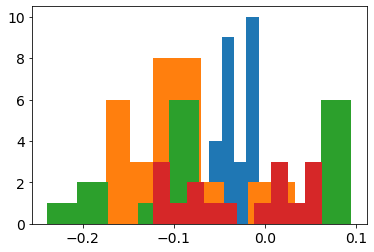

In [23]:
plt.hist(ws[wmap['conv1_bias']])
plt.hist(ws[wmap['conv2_bias']])
plt.hist(ws[wmap['conv3_bias']])
plt.hist(ws[wmap['conv4_bias']]);

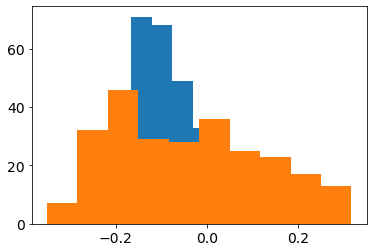

In [28]:
plt.hist(ws[wmap['f1_bias']])
plt.hist(ws[wmap['f2_bias']]);
# plt.hist(ws[wmap['f3_bias']]);

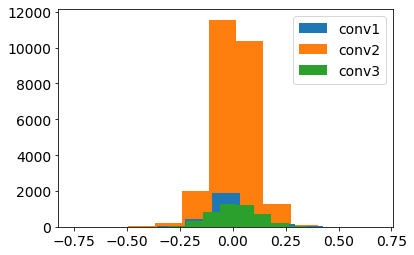

In [46]:
plt.hist(ws[wmap['conv1']].flatten(), label='conv1', zorder=1);
plt.hist(ws[wmap['conv2']].flatten(), label='conv2', zorder=0);
plt.hist(ws[wmap['conv3']].flatten(), label='conv3', zorder=2);
plt.legend();

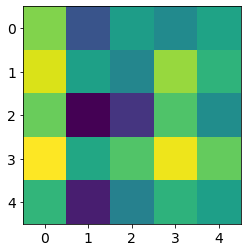

In [192]:
for i in range(4):
    plt.figure()
    plt.imshow(ws[wmap['conv1']][:, :, i, 0])

In [92]:
no_fc_model = Model(inputs=model.keras_model.inputs, outputs=model.keras_model.layers[-4].output)

In [116]:
def prediction(rope_configuration):
    # predict
    sdf_data = link_bot_pycommon.SDF.load("./data/train_1_10/sdf_data_0.npz")
    rope_images = link_bot_pycommon.make_rope_images(sdf_data, rope_configuration)
    x = {
        'sdf': sdf_data.sdf[np.newaxis, :, :, np.newaxis],
        'rope_image': rope_images,
    }
    y = no_fc_model.predict(x)
    
    return y, sdf_data
    
def viz(sdf_data, rope_configuration):
    # viz
    plt.figure()
    plt.title("histogram of latent vector")
    plt.hist(y.flatten());

    plt.figure()
    plt.title("Scene")
    plt.imshow(sdf_data.image, extent=sdf_data.extent);
    plt.plot([rope_configuration[0], rope_configuration[2], rope_configuration[4]],
             [rope_configuration[1], rope_configuration[3], rope_configuration[5]], c='w')
    plt.scatter(rope_configuration[4], rope_configuration[5], c='r', zorder=3)


In [125]:
for head_x in np.arange(0.6, 1.9, 0.05):
    rope_configuration = link_bot_pycommon.make_rope_configuration(head_x, -0.3, 2.5, 1.5)
    if np.allclose(head_x, 1.5):
        print("==================")
    y, sdf_data = prediction(rope_configuration)
    print(y.mean())
# viz(sdf_data, rope_configuration)

-2.2881827
-2.2942214
-2.2403643
-2.202896
-2.186053
-2.196268
-2.185882
-2.1532583
-2.0864134
-2.0254917
-1.9566567
-1.8151846
-1.7847931
-1.8109173
-1.7810502
-1.7037916
-1.659621
-1.7113295
-1.7109559
-1.4942433
-1.5295522
-1.6877726
-1.7218459
-1.8434043
-1.8550496
-1.9547008


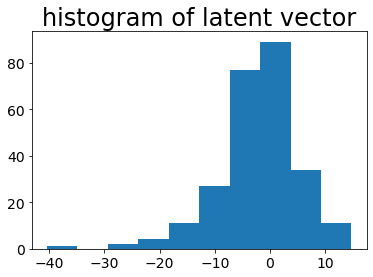

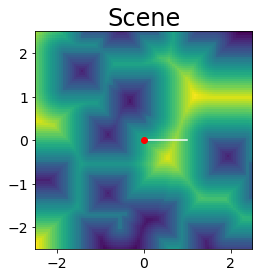

In [147]:
rope_configuration = link_bot_pycommon.make_rope_configuration(0, 0, 0, 0)
y, sdf_data = prediction(rope_configuration)
viz(sdf_data, rope_configuration)

-63.229683 0.8401036
-166.51553 0.0008094188
-149.45068 0.006139911
-240.8481 0.0024850646
-257.8818 0.0038659298
-281.47736 0.0051642023
-129.59424 0.017230662
-244.33752 0.0016063101
-247.14708 0.0010784782
-122.45027 0.00031410748
-158.66391 0.99990773
-181.01965 0.0006198986
-188.74994 0.0066488907
-75.53927 0.00011448632
-12.979022 1.3476612e-05
-5.4802794 4.1627723e-06
-1.6266195 3.0211056e-06
-1.4354503 2.3178752e-06
-2.0615296 1.9025916e-06
-1.0400088 1.6352935e-06
-0.7888064 1.4059052e-06
-1.5798438 1.2661628e-06
-0.5090715 1.1541591e-06
-0.46381834 1.0509211e-06
-0.9158748 9.855135e-07
-0.35087085 9.114894e-07
-0.9931695 8.538595e-07
-0.39833552 8.112895e-07
-0.62405306 7.570926e-07
-0.6051073 7.284938e-07
-0.5487572 6.893216e-07
-0.30538377 6.626625e-07
-0.87021625 6.3478524e-07
-0.2125522 6.1223824e-07
-0.41518867 5.84033e-07
-0.7782005 5.674165e-07
-0.19041331 5.483308e-07
-0.78652126 5.277124e-07
-0.18832786 5.1517833e-07
-0.34376365 4.956076e-07
-0.51003945 4.849601e-07


-0.08198388 6.1293285e-08
-0.1894214 6.166524e-08
-0.04161942 6.200858e-08
-0.03040032 6.156829e-08
-0.06811125 6.1171825e-08
-0.086791985 6.086933e-08
-0.08731627 6.0852734e-08
-0.044140764 6.067865e-08
-0.049224384 6.040198e-08
-0.11113367 6.021586e-08
-0.033086997 6.0195994e-08
-0.054229017 5.995673e-08
-0.25838694 5.983724e-08
-0.030019041 6.079635e-08
-0.040541735 6.0402556e-08
-0.05617217 5.998259e-08
-0.029455699 5.965423e-08
-0.1269376 5.9456113e-08
-0.037895992 5.9403533e-08
-0.08504702 5.9269418e-08
-0.04298841 5.909389e-08
-0.047965102 5.8856198e-08
-0.09465821 5.875706e-08
-0.05299842 5.8596108e-08
-0.23219286 5.8616234e-08
-0.02927734 5.9293946e-08
-0.039540138 5.890944e-08
-0.05481175 5.8530095e-08
-0.06761692 5.8258003e-08
-0.054519556 5.8216894e-08
-0.096709654 5.7957426e-08
-0.021572456 5.7887053e-08
-0.058224864 5.767908e-08
-0.084231205 5.7487533e-08
-0.040251765 5.738828e-08
-0.20831215 5.7484797e-08
-0.02450832 5.783959e-08
-0.054705407 5.7487096e-08
-0.046032798 5

-0.02613763 3.4427565e-08
-0.026052557 3.4315267e-08
-0.036279827 3.4216058e-08
-0.058348507 3.4168835e-08
-0.036199193 3.4140044e-08
-0.058042116 3.4069206e-08
-0.013943812 3.4053937e-08
-0.07968833 3.4001694e-08
-0.060352817 3.416395e-08
-0.025862135 3.406459e-08
-0.025778107 3.3953924e-08
-0.04883673 3.389e-08
-0.06037642 3.3857308e-08
-0.027638122 3.38222e-08
-0.06084633 3.378403e-08
-0.07499546 3.3784936e-08
-0.0187972 3.3856725e-08
-0.045862295 3.376554e-08
-0.041714884 3.3713288e-08
-0.030766936 3.3640834e-08
-0.045301277 3.3568657e-08
-0.027393397 3.352246e-08
-0.08619793 3.3511018e-08
-0.030645745 3.3508524e-08
-0.07435503 3.3495553e-08
-0.034294892 3.3562e-08
-0.025396915 3.345163e-08
-0.064376324 3.3373116e-08
-0.03314776 3.3340854e-08
-0.030447803 3.3291865e-08
-0.0607367 3.3233242e-08
-0.02036558 3.321461e-08
-0.07778773 3.318903e-08
-0.058876015 3.3327822e-08
-0.025229832 3.3231657e-08
-0.020323763 3.3129073e-08
-0.05087238 3.3067202e-08
-0.05568868 3.3032787e-08
-0.04082

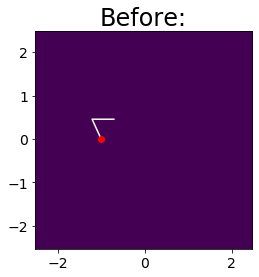

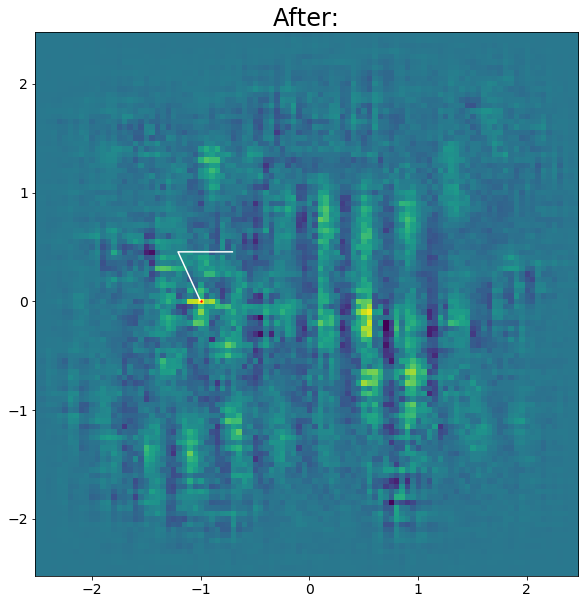

In [227]:
loss = K.mean(model.keras_model.layers[-1].output)
grads = K.gradients(loss, model.keras_model.inputs[0])
grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)

iterate = K.function(model.keras_model.inputs,[loss,grads])

step = 0.05

sdf_data = link_bot_pycommon.SDF.load("./data/train_1_10/sdf_data_0.npz")
rope_configuration = link_bot_pycommon.make_rope_configuration(-1.0, 0, 2, 0)
rope_images = link_bot_pycommon.make_rope_images(sdf_data, rope_configuration)
x = {
    'sdf': sdf_data.sdf[np.newaxis, :, :, np.newaxis],
    'rope_image': rope_images,
}

Z_in = x['sdf']
Z_in = np.zeros_like(x['sdf'])
Z_adapt = Z_in.copy()

while True:
    loss_val, grads_val = iterate([Z_adapt, rope_images])
    clipped_grad = np.clip(grads_val[0], -1, 1)
    Z_adapt -= clipped_grad * step
    m = np.sum(grads_val)
    print(m, loss_val)
    if abs(m) < 0.01:
        break
        
extent = sdf_data.extent - np.array([sdf_data.resolution[0]/2, sdf_data.resolution[0]/2, sdf_data.resolution[0]/2, sdf_data.resolution[0]/2])

plt.figure()
plt.title("Before:")
plt.imshow(np.flipud(Z_in.squeeze().T), extent=extent)
plt.plot([rope_configuration[0], rope_configuration[2], rope_configuration[4]],
         [rope_configuration[1], rope_configuration[3], rope_configuration[5]], c='w')
plt.scatter(rope_configuration[4], rope_configuration[5], c='r', zorder=3)

plt.figure(figsize=(10,10))
plt.title("After:")
plt.imshow(np.flipud(Z_adapt.squeeze().T), extent=extent)
plt.plot([rope_configuration[0], rope_configuration[2], rope_configuration[4]],
         [rope_configuration[1], rope_configuration[3], rope_configuration[5]], c='w')
plt.scatter(rope_configuration[4], rope_configuration[5], c='r', zorder=3, s=2)
None;

In [230]:
keras.utils.plot_model(model.keras_model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [231]:
!pip install pydot